# Collisions and Injuries in Montgomery
By Ulysses Zamora and Elijah Barsky-Ex

The report is about how our team investigated the connections between the different brands of cars commonly found in Montgomery County, Maryland, and the safety of their drivers. This safety information we gathered by looking at columns like vehicle damage extent and injury severity. This was the primary connection we focused on, although we also investigated adjacent relevent columns such as speed limit.

The data comes from Montgomery County, Maryland, and is vehicle crash data. It is collected and updated weekly by the local police department. This dataset has over 130,000 rows, and 43 columns, where each row is one driver. Some of the columns are irrelevant from a data science perspective, such as: report number, local case number, agency name, etc. Other columns have a significant amount of potential, such as: speed limit, vehicle damage extent, injury severity, etc.


#Initial Exploration
Initilizing data and dropping rows that are not going to be needed and taking a look at the data using df.info()

Based off of df.info() most of the columns are of type object which means there many of them are categorical

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
drive.mount('/content/drive');
data_dir = "/content/drive/My Drive/Crash_Reporting_-_Drivers_Data.csv"
df = pd.read_csv(data_dir)

rcParams['figure.figsize'] = 10,6
sns.set_context('notebook')
df.index = pd.to_datetime(df['Crash Date/Time'])
df = df.sort_index()

# drop the columns that won't be used (this depends completely on your project)
df = df.drop(['Report Number', 'Local Case Number', 'Agency Name', 'Road Name', 'Cross-Street Type', 'Cross-Street Name',
              'Off-Road Description', 'Municipality', 'Traffic Control', 'Non-Motorist Substance Abuse', 'Person ID',
              'Circumstance', 'Driver Distracted By', 'Vehicle ID', 'Vehicle Continuing Dir', 'Vehicle Going Dir', 
              'Vehicle Model', 'Equipment Problems'], axis=1)

df.info();

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131610 entries, 2015-01-01 00:30:00 to 2021-10-21 09:26:00
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ACRS Report Type                131610 non-null  object 
 1   Crash Date/Time                 131610 non-null  object 
 2   Route Type                      118773 non-null  object 
 3   Related Non-Motorist            4089 non-null    object 
 4   Collision Type                  131176 non-null  object 
 5   Weather                         121261 non-null  object 
 6   Surface Condition               116111 non-null  object 
 7   Light                           130504 non-null  object 
 8   Driver Substance Abuse          107621 non-null  object 
 9   Driver At Fault                 131610 non-null  object 
 10  Injury Severity                 131610 non-null  object 
 11  Drivers License State           124868 non-n

To get a feel to see if we would need to do a lot of data cleaning we looked at the amount of NA values per column and we found that many of the columns included NA values with 'Related Non-Motorist' having the most na values.

In [2]:
df.isna().sum()

ACRS Report Type                       0
Crash Date/Time                        0
Route Type                         12837
Related Non-Motorist              127521
Collision Type                       434
Weather                            10349
Surface Condition                  15499
Light                               1106
Driver Substance Abuse             23989
Driver At Fault                        0
Injury Severity                        0
Drivers License State               6742
Vehicle Damage Extent                239
Vehicle First Impact Location        156
Vehicle Second Impact Location       256
Vehicle Body Type                   1936
Vehicle Movement                     271
Speed Limit                            0
Driverless Vehicle                     0
Parked Vehicle                         0
Vehicle Year                           0
Vehicle Make                          22
Latitude                               0
Longitude                              0
Location        

In [3]:
df.describe()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,131610.000000,131610.000000,131610.000000,131610.000000
mean,32.773915,1967.990662,39.082425,-77.112352
std,11.047232,332.768402,0.072250,0.099441
min,0.000000,0.000000,37.720000,-79.486000
25%,30.000000,2005.000000,39.023480,-77.188382
50%,35.000000,2010.000000,39.074436,-77.105261
75%,40.000000,2014.000000,39.138233,-77.039914
max,70.000000,9999.000000,39.990414,-75.527708


# Data Cleaning and Variable Setting

Since we are looking at vehicle makes in a portion of the exploration there are times where the types of cars are abbrevaited such as 'HOND' or 'TOYT', so were changing them to their respective names

In [4]:
df['Vehicle Make'] = df['Vehicle Make'].replace(['TOYT', 'HOND'], ['TOYOTA', 'HONDA'])

For one of our visualizations we wanted to look at the top vehicle makes and look to see if the extent of the damage was more severe with a certain type of make so we made a variable called new_data with only the top 5 cars. We also edited the column 'Vehicle Damage Extent' to remove values that would not be beneficial.

In [5]:
df.dropna(subset=['Vehicle Make'], inplace=True)
new_data = (((df['Vehicle Make'] == 'HONDA') ) 
| ((df['Vehicle Make'] == 'TOYOTA') ) 
| ((df['Vehicle Make'] == 'FORD') ) 
| ((df['Vehicle Make'] == 'NISSAN') ) 
| ((df['Vehicle Make'] == 'DODGE')))
new_data = df[new_data].drop('Crash Date/Time', axis=1)
new_data['Vehicle Damage Extent'] = new_data['Vehicle Damage Extent'].replace(['OTHER', 'SUPERFICIAL', 'UNKNOWN'], np.nan)
new_data.dropna(subset=['Vehicle Damage Extent'], inplace=True)

We also wanted to see if the year of the top vehicle makes had any affext on the severity of the injury so we edited the column 'Vehicle Year' in the new_data variable to include two sets of years from new to old.

In order to make the data more general also we grouped values in the 'Injury Severity' column to make it more general instead of having many values. Serious and Fatal injuries were grouped together and minor and possible injury were grouped together.

In [6]:
new_data['Injury Severity'] = new_data['Injury Severity'].replace(['FATAL INJURY', 'SUSPECTED SERIOUS INJURY', 'POSSIBLE INJURY', 'SUSPECTED MINOR INJURY'], 
                                                                  ['SERIOUS INJURY', 'SERIOUS INJURY', 'MINOR INJURY', 'MINOR INJURY'])

# Data Exploration and Visualization

## Question
One of our main questions was to determine what car models appeared to be the safest after a crash, so to start off we created a density plot to get an idea of the speed limit that most of the accidents were occuring at.

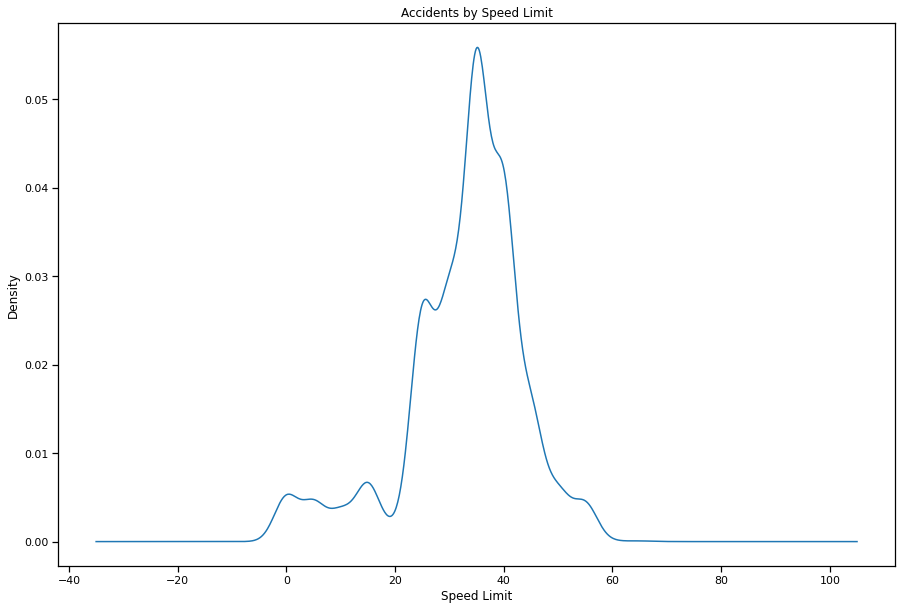

In [7]:
df['Speed Limit'].plot.kde(bw_method=.2, figsize=(15,10));
plt.title('Accidents by Speed Limit')
plt.xlabel('Speed Limit');

## Results
The Result of the desity plot was very interesting. It showed that many of the accidents happened from around 30-45 mph, which makes sense becuase there are rarely cars going 80+ mph. It is interesting to note however, that there appeared to be less accidents at speeds that you see on the freeway where one would think accidents were more prone to happen.

## Question
Our next question was whether the speed limit in the area was an influencing
factor in whether the officer found the driver at fault.


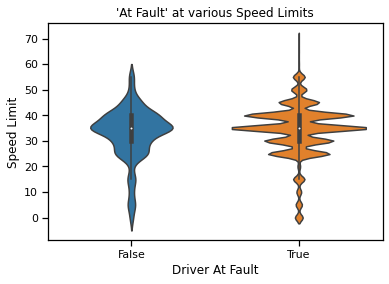

In [8]:
new_data['Driver At Fault'] = (new_data['Driver At Fault'] != 'Unknown')
sns.violinplot(x='Driver At Fault', y='Speed Limit', data=new_data, figsize=(15,10))
plt.title("'At Fault' at various Speed Limits");

## Result 
While the driver being at fault did not seem to have a strong correlation with the speed limit, it is interesting to note the jaggedness of the violin plot where they were found at fault.

## Question
To start answering the question of what car makes appeared to be the most safe, We looked to see what were the top 5 vechicle makes due to there being too many in the dataset. (Note: 'TOYT' and 'HOND' appearead in the dataset, so they were changed to 'TOYOTA' and 'HONDA' to give a more accurate result.

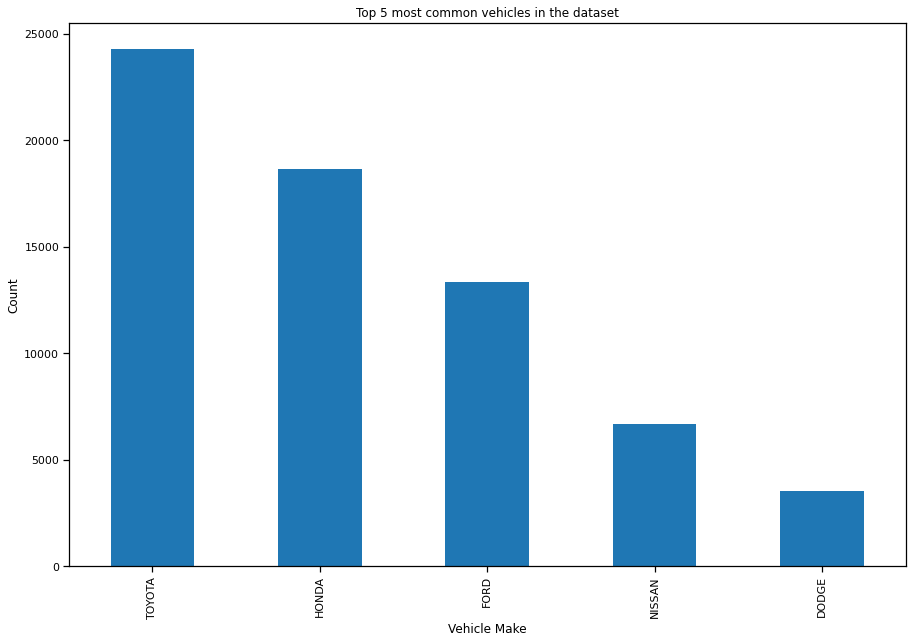

In [9]:
df['Vehicle Make'].value_counts()[:5].plot.bar(figsize=(15,10))
plt.title('Top 5 most common vehicles in the dataset')
plt.xlabel('Vehicle Make')
plt.ylabel('Count');

## Result
Toyota, Honda, Ford, Nissan, and Dodge were the top cars per accident in the dataset.

## Question
To continue exploring the data and get a feel for the severity of the vehicles we wanted to see if any older vehicle models resulted in there being more significant injuries.

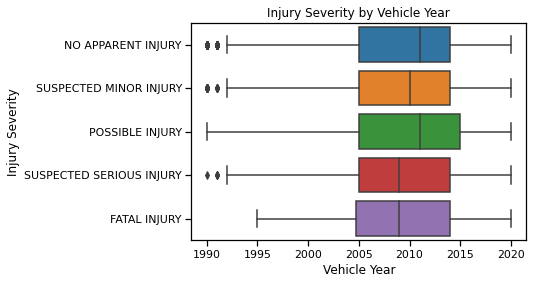

In [10]:
df = df[df['Vehicle Year'] < 2021]
df = df[df['Vehicle Year'] > 1989]
sns.boxplot(x='Vehicle Year', y='Injury Severity', data=df)
plt.title('Injury Severity by Vehicle Year');

## Result
The box plot showed that the median of the serious and fatal injuries were lower in terms of years but that does not necessarily mean that they are less safe because they are all relatively the same. 

## Question
To start investigating what cars were the safest we looked at only the top five cars and then compared them each with to the extent of the vehicle to see if we noticed any trends. (Note: 'OTHER', 'SUPERFICIAL' and 'UNKNOWN' were removed because they don't add to the investigation.

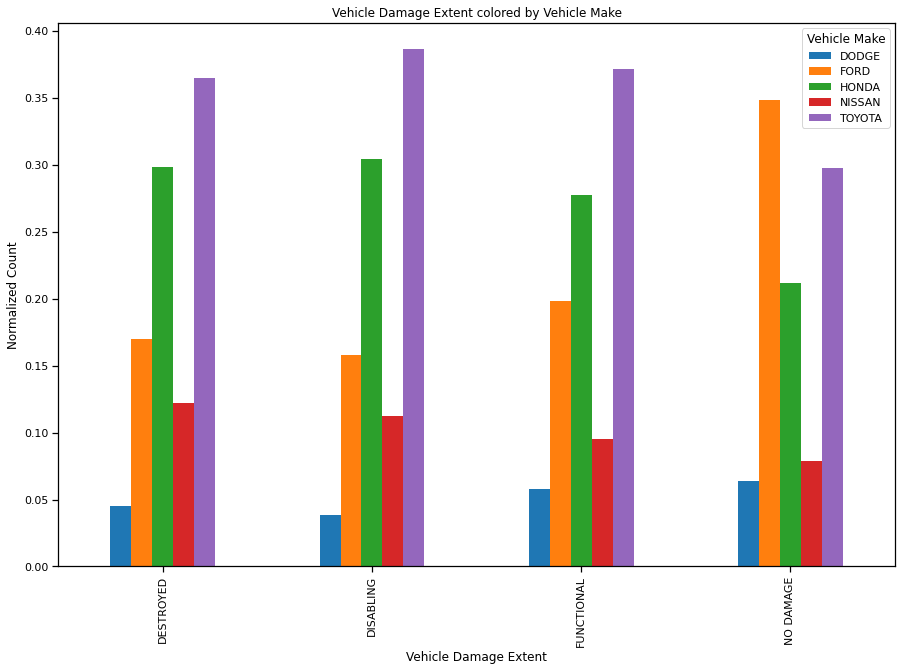

In [11]:
pd.crosstab(new_data['Vehicle Damage Extent'], new_data['Vehicle Make'], normalize='index').plot.bar(figsize=(15,10))
plt.title('Vehicle Damage Extent colored by Vehicle Make')
plt.ylabel('Normalized Count');


## Result
This showed us that Honda, Toyota and Ford were the least effected by a substabntial amount after a crash as they are the biggest and most dominant bars in the 'NO DAMAGE' and 'FUNCTIONAL' columns, but we noticed that the bars for 'DESTROYED' and 'DISABLING' where also very high. This could be because they are the most dominant in terms of numbers.
## Question 
Based off the info from the last graph we then wanted to know if certain makes led to more serious injuries. (Note: For clarity 'FATAL INJURY' and 'SUSPECTED SERIOUS INJURY' were grouped into a 'SERIOUS INJURY' column and 'POSSIBLE INJURY' and 'SUSPECTED MINOR INJURY' were grouped into a 'MINOR INJURY' column.

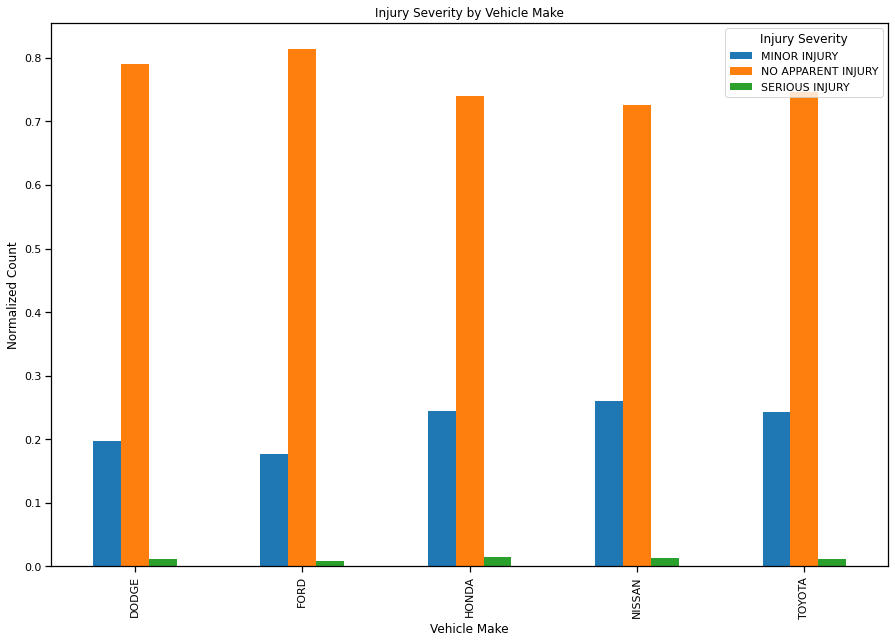

In [12]:
pd.crosstab(new_data['Vehicle Make'], new_data['Injury Severity'],normalize='index').plot.bar(figsize=(15,10))
plt.title('Injury Severity by Vehicle Make')
plt.ylabel('Normalized Count');

## Result
As expetced many of the makes led to no apparent injuries, showing that they are all relativaly the same when it comes to saftey. What was interesting from looking at the grouped bar plot was that they all had relatively the same amount of minor injury and serious injury. 
## Question 
So to get a deeper look into this information, we wanted to see if the severity of the damage to the car had any relationship to the kind of injury that was sustained. (Note: Instead of now separting by vehicle make, the top five makes are grouped together to get a general answer)

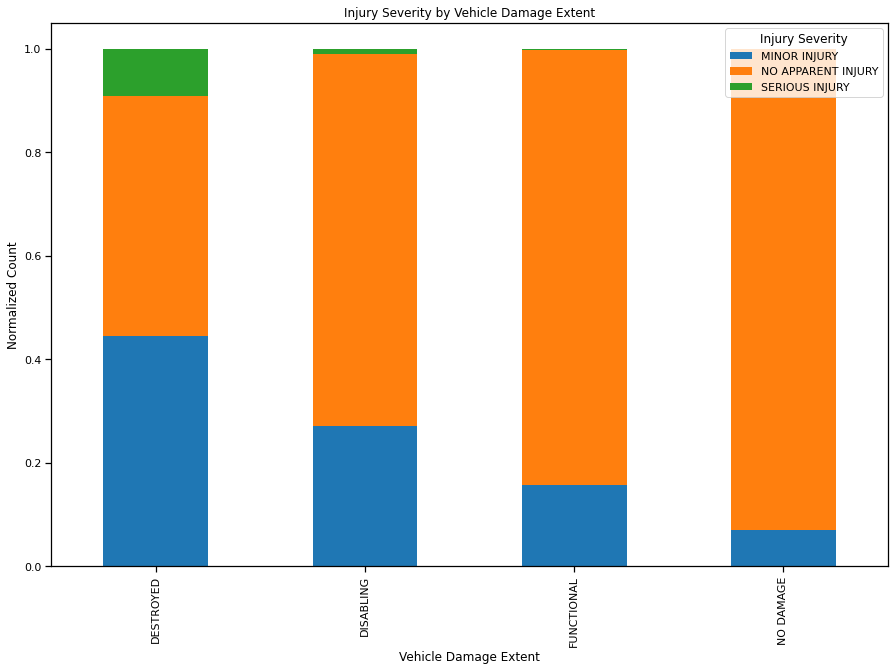

In [13]:
pd.crosstab(new_data['Vehicle Damage Extent'], new_data['Injury Severity'],normalize='index').plot.bar(stacked=True,figsize=(15,10))
plt.title('Injury Severity by Vehicle Damage Extent')
plt.ylabel('Normalized Count');

## Result
The results did show that as the cars got less damaged the severity of the injruy also went down. For example, when looking at destroyed as opposed to no damage, the bars of Minor injury and Serious injury are significantly higher.
## Question
Based off the result of the previous graph and looking at the wide spread of injuries we wanted to see what type of collision types were the most prominent in crashes were there was no apparent injury as opposed to a serious injury. For the sake of making the data less spread out Fatal Injuries and Suspected Serious Injuries are grouped together.

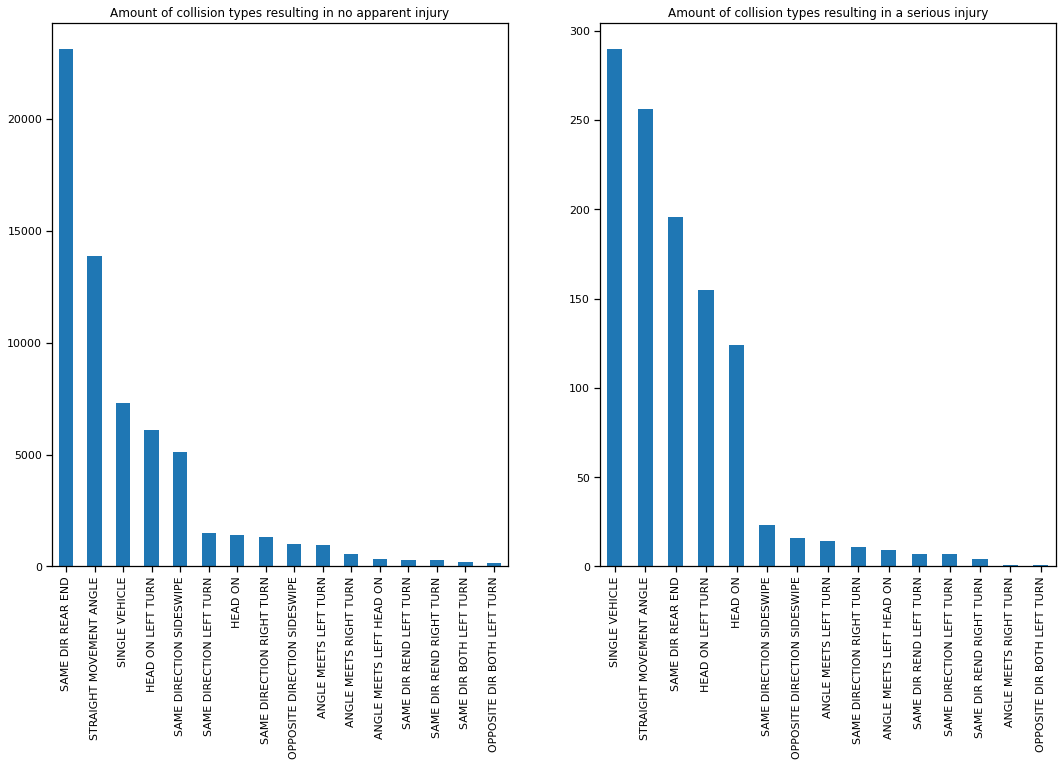

In [14]:
# Making new variable and doing the same cleaning and grouping as new_data
data_all_cars = df 
data_all_cars['Injury Severity'] = data_all_cars['Injury Severity'].replace(['FATAL INJURY', 'SUSPECTED SERIOUS INJURY', 'POSSIBLE INJURY', 'SUSPECTED MINOR INJURY'], 
                                                                  ['SERIOUS INJURY', 'SERIOUS INJURY', 'MINOR INJURY', 'MINOR INJURY'])
data_all_cars = data_all_cars.drop('Crash Date/Time', axis=1)
data_all_cars['Vehicle Damage Extent'] = data_all_cars['Vehicle Damage Extent'].replace(['OTHER', 'SUPERFICIAL', 'UNKNOWN'], np.nan)
data_all_cars.dropna(subset=['Vehicle Damage Extent'], inplace=True)

fig, axs = plt.subplots(1,2)

data_all_cars['Collision Type'][(data_all_cars['Vehicle Damage Extent'] == data_all_cars['Vehicle Damage Extent']) & (data_all_cars['Injury Severity'] == 'NO APPARENT INJURY')
& (data_all_cars["Collision Type"] != "UNKNOWN") & (data_all_cars["Collision Type"] != "OTHER")].value_counts().plot(ax=axs[0], kind='bar', figsize=(18,10));
data_all_cars['Collision Type'][(data_all_cars['Vehicle Damage Extent'] == data_all_cars['Vehicle Damage Extent']) & (data_all_cars['Injury Severity'] == 'SERIOUS INJURY') 
& (data_all_cars["Collision Type"] != "UNKNOWN") & (data_all_cars["Collision Type"] != "OTHER")].value_counts().plot(ax = axs[1], kind='bar', figsize=(18,10))

axs[0].title.set_text('Amount of collision types resulting in no apparent injury')
axs[1].title.set_text('Amount of collision types resulting in a serious injury');

## Result
The two graphs were very interesting to look at and it showed that in crashes were the was a serious injury the leading type of collision was a single vechile, which is often associated with driving while intoxicated.
## Question
To answer this question we combined all the values in 'DRIVER SUBSTANCE ABUSE' that had some relation to intoxication into one general category 'INTOXICATED' to get a more general result. We wanted to see if being intoxicated was the leading cause of a single vehicle collision to prove our hypothesis.

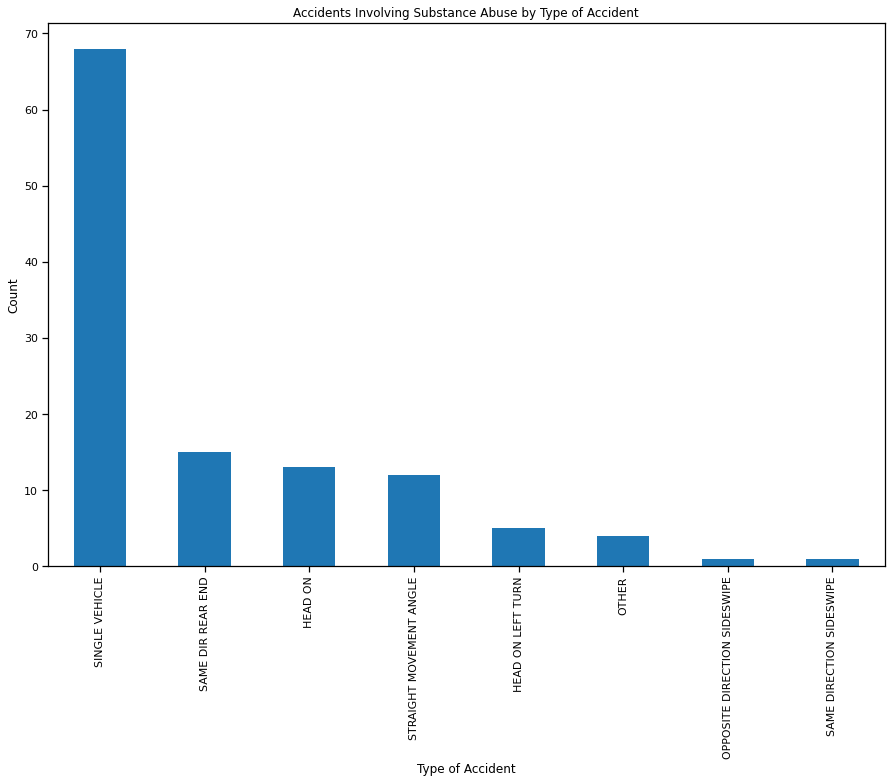

In [15]:
# Editing column to make all values that invlove some sort of intoxication and combining them into one value 'INTOXICATED'
data_all_cars['Driver Substance Abuse'] = data_all_cars['Driver Substance Abuse'].replace(['ALCOHOL PRESENT', 'ALCOHOL CONTRIBUTED', 'ILLEGAL DRUG PRESENT', 'ILLEGAL DRUG CONTRIBUTED',
                                                                                           'MEDICATION PRESENT', 'COMBINED SUBSTANCE PRESENT', 'MEDICATION CONTRIBUTED', 'COMBINATION CONTRIBUTED'], 
                                                                  ['INTOXICATED', 'INTOXICATED', 'INTOXICATED', 'INTOXICATED', 'INTOXICATED', 'INTOXICATED', 'INTOXICATED', 'INTOXICATED',])
data_all_cars['Collision Type'][(data_all_cars['Driver Substance Abuse'] == 'INTOXICATED') & (data_all_cars['Injury Severity'] == 'SERIOUS INJURY')].value_counts().plot.bar(figsize=(15,10))
plt.title('Accidents Involving Substance Abuse by Type of Accident')
plt.xlabel('Type of Accident')
plt.ylabel('Count');

## Result 
Our hypothesis was proven correct because Single vehicle colissions was the leader by a landslide when the driver was intoxicated.

##Conclusion

The data and visualizations in the project showed us quite a few connections and conclusions, with many more still hidden. For example, while it was shown that accidents involving older vehicles have more fatal injuries, and most serious injury collisions only involved one vehicle. We also discovered that most of the crashes that led to a severe injury came from a head on collision in which most of the drivers were intoxicated by at least one substance. Some issues we found were trying to find relevant data were the amount of values in the column weren't so one sided towards one value, and dealing with the varying types of NA data, as well as clearly incorrect data.